# Thesis

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from grid_cells import get_grid_cells, purge_delinquent_cells
from environment import GridCellWorld
from utils import get_coords, device, to_tensor
from agent import Agent
from torch.optim import Adam
from tqdm import tqdm

In [3]:
resolution = 400
MIN, MAX = -1, 1
N = 100

coords = get_coords(resolution, MIN, MAX)
# grid_cells = get_grid_cells(np.linspace(40, 150, 30), N, resolution)
# grid_cells = purge_delinquent_cells(grid_cells)
grid_cells = np.load("grid_cells.npy")

In [4]:
c, gc = to_tensor(coords), to_tensor(grid_cells)

In [14]:
env = GridCellWorld(gc, c)
agent = Agent(grid_cells.shape[-1], 2, action_amp=0.1, bs=256, actor_hidden=1024, critic_hidden=2048)

In [15]:
n_episodes = 5000
episode_max_len = 50

rewards = list()
lengths = list()
for ep in tqdm(range(n_episodes)):
    done = False
    step = 0
    reward = list()
    s, loc = env.reset(end_radius=0.25), env.state
    while not done and step < episode_max_len:
        a = agent.choose_action(s)
        s_new, r, done = env.next_state(a)
        agent.remember(s.detach(), a.detach(), r.detach(), s_new.detach(), done, loc.detach())
        agent.learn()
        s, loc = s_new, env.state
        step += 1
        reward.append(r)
    lengths.append(step)
    rewards.append(sum(reward).detach().cpu())

  2%|█▋                                                                           | 111/5000 [02:42<1:59:23,  1.47s/it]


KeyboardInterrupt: 

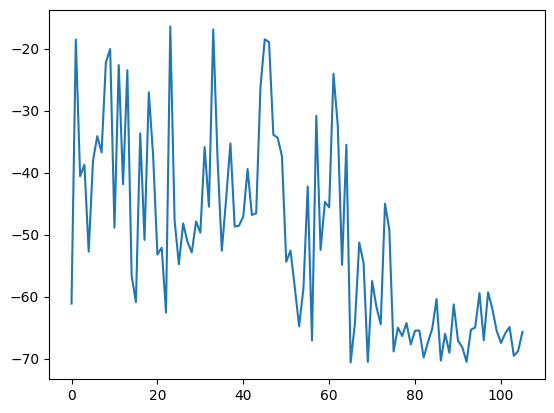

In [16]:
plt.plot(to_tensor(rewards).cpu()[np.asarray(lengths) == 50])

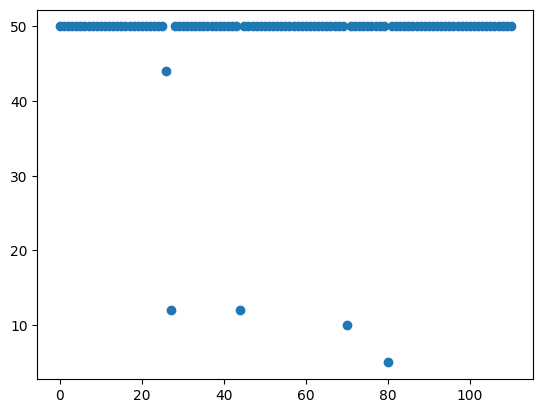

In [17]:
plt.scatter(np.arange(len(lengths)), lengths)

In [ ]:
states = []
s = env.reset()
env.state = np.array([0.5, -1])
s = env.grid_cells[env.closest_coord_index(env.state)]
states.append(env.state)
step = 0
done = False
while not done and step < episode_max_len:
    a = agent.choose_action(s, evaluate=True)
    s_new, r, done = env.next_state(a)
    s = s_new
    states.append(env.state)
    step += 1

In [ ]:
plt.plot(*np.asarray(states).T)

In [ ]:
hidden = 100

net = nn.Sequential(
    nn.Linear(grid_cells.shape[-1], hidden),
    nn.Sigmoid(),
    nn.Linear(hidden, 2),
    nn.Tanh()
).to(device)

optim = Adam([p for p in net.parameters()], lr=3e-4, weight_decay=1e-5)

In [ ]:
def get_batch(coords, grid_cells, bs=64):
    states = torch.rand(bs, 2, device=device) * 2 - 1
    distances = torch.abs(torch.unsqueeze(coords, 2) - states).sum(axis=-1)
    idx = distances.view(-1, bs).argmin(0)
    rr = idx // coords.shape[0]
    cc = idx % coords.shape[1]
    return grid_cells[(rr, cc)], states

In [ ]:
losses = list()
for _ in tqdm(range(1000)):
    optim.zero_grad()
    x, y = get_batch(c, gc, bs=256)
    loss = torch.sum((net(x) - y)**2, dim=-1).mean()
    loss.backward()
    optim.step()
    losses.append(loss.detach().cpu().item())

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
idx = net[2].weight.detach().cpu().abs().argsort(dim=-1)[:,-10:].numpy() + [[0], [hidden]]
net[2].weight.detach().cpu().flatten()[idx.flatten()]

In [ ]:
hidden = (gc @ net[0].weight.T).detach().cpu().numpy().transpose((-1, 0, 1))
idx = net[2].weight.detach().cpu().abs().argsort(dim=-1)[:,-10:]
for img in hidden[idx.flatten()]:
    plt.contourf(img, levels=20, cmap='hot')
    plt.show()